In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
dataset=pd.read_csv('./diabetes.csv')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [2]:
x=dataset.drop('Outcome',axis=1)
y=dataset['Outcome']

In [3]:
# from sklearn.impute import KNNImputer
# imputer=KNNImputer(missing_values=0,n_neighbors=9)

# print(x.iloc[:,1:8])
# imputer.fit(x.iloc[:,1:8])
# x.iloc[:,1:8]=imputer.transform(x.iloc[:,1:8])
# print(x.iloc[:,1:8].values)

In [3]:
for i in x.columns:
    sum=0
    for d in x[i]:
        if d==0:
            sum+=1
    print(i,sum)

Pregnancies 111
Glucose 5
BloodPressure 35
SkinThickness 227
Insulin 374
BMI 11
DiabetesPedigreeFunction 0
Age 0


In [4]:
df=dataset.copy()
for i in ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']:
    df=df[df[i]!=0]

for i in x.columns:
    sum=0
    for d in df[i]:
        if d==0:
            sum+=1
    print(i,sum)


Pregnancies 56
Glucose 0
BloodPressure 0
SkinThickness 0
Insulin 0
BMI 0
DiabetesPedigreeFunction 0
Age 0


In [5]:
x=df.copy().drop('Outcome',axis=1)
y=df['Outcome']

from sklearn.feature_selection import f_classif

# compute F-statistics and initialize correlation matrix
F = pd.Series(f_classif(x, y)[0], index = x.columns)
corr = pd.DataFrame(.00001, index = x.columns, columns = x.columns)

# initialize list of selected features and list of excluded features
selected = []
not_selected = x.columns.to_list()

K=3
# repeat K times
for i in range(K):
  
    # compute (absolute) correlations between the last selected feature and all the (currently) excluded features
    if i > 0:
        last_selected = selected[-1]
        print(last_selected)
        corr.loc[not_selected, last_selected] = x[not_selected].corrwith(x[last_selected]).abs().clip(.00001)
        
    # compute FCQ score for all the (currently) excluded features (this is Formula 2)
    score = F.loc[not_selected] / corr.loc[not_selected, selected].mean(axis = 1).fillna(.00001)
    print("score in {} iteration".format(i),score)
    # find best feature, add it to selected and remove it from not_selected
    best = score.index[score.argmax()]
    selected.append(best)
    print(selected)
    not_selected.remove(best)
    print(not_selected)



score in 0 iteration Pregnancies                 2.748115e+06
Glucose                     1.412985e+07
BloodPressure               1.503615e+06
SkinThickness               2.733684e+06
Insulin                     3.897663e+06
BMI                         3.069562e+06
DiabetesPedigreeFunction    1.787250e+06
Age                         5.472994e+06
dtype: float64
['Glucose']
['Pregnancies', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
Glucose
score in 1 iteration Pregnancies                 138.589980
BloodPressure                71.591667
SkinThickness               137.470660
Insulin                      67.059689
BMI                         146.507321
DiabetesPedigreeFunction    127.496637
Age                         159.264633
dtype: float64
['Glucose', 'Age']
['Pregnancies', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction']
Age
score in 2 iteration Pregnancies                  62.606600
BloodPressure            

In [6]:
print(selected)
print(not_selected)

['Glucose', 'Age', 'BMI']
['Pregnancies', 'BloodPressure', 'SkinThickness', 'Insulin', 'DiabetesPedigreeFunction']


In [7]:
x_set=np.concatenate((df['Glucose'].to_numpy().reshape(len(df['Glucose']),1),
                      df['Insulin'].to_numpy().reshape(len(df['Glucose']),1),
                      df['Age'].to_numpy().reshape(len(df['Glucose']),1)),axis=1)
y_set=y

In [8]:
from sklearn.model_selection import train_test_split
X_train1,X_test1,y_train1,y_test1=train_test_split(x_set,y_set,random_state=44,stratify=y_set)

In [9]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X_train1=sc.fit_transform(X_train1)
X_test1=sc.fit_transform(X_test1)

In [10]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,roc_curve,roc_auc_score
classifier=SVC(kernel="linear",C=1)
classifier.fit(X_train1,y_train1)
print("Score of SVM with linear kernel")
lsvmy_pred=classifier.predict(X_test1)
cm=confusion_matrix(y_test1,lsvmy_pred)
print(cm)
print(accuracy_score(y_test1,lsvmy_pred))

print("OUTCOME DIABETIC\n")
print("Mis-classification(1-accuracy)",(cm[0][1]+cm[1][0])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1]))
Sensitivity=cm[1][1]/(cm[1][1]+cm[1][0])
print("sensitivity",Sensitivity)
print("Specificity(TNR):",cm[0][0]/(cm[0][0]+cm[0][1]))
Precision=cm[1][1]/(cm[1][1]+cm[0][1])
print("precision",Precision)
print("f1 score",2*Precision*Sensitivity/(Precision+Sensitivity))

print("OUTCOME NON DIABETIC")
print("Mis-classification(1-accuracy)",(cm[0][1]+cm[1][0])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1]))
Sensitivity=cm[0][0]/(cm[0][0]+cm[0][1])
print("sensitivity",Sensitivity)
print("Specificity(TNR):",cm[1][1]/(cm[1][1]+cm[1][0]))
Precision=cm[0][0]/(cm[0][0]+cm[1][0])
print("precision",Precision)
print("f1 score",2*Precision*Sensitivity/(Precision+Sensitivity))







classifierrbf=SVC(kernel="rbf",C=0.1).fit(X_train1,y_train1)
print("Score of SVM with rbf kernel")
rbfsvmy_pred=classifierrbf.predict(X_test1)
print(confusion_matrix(y_test1,rbfsvmy_pred))
print(accuracy_score(y_test1,rbfsvmy_pred))

print("OUTCOME DIABETIC\n")
print("Mis-classification(1-accuracy)",(cm[0][1]+cm[1][0])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1]))
Sensitivity=cm[1][1]/(cm[1][1]+cm[1][0])
print("sensitivity",Sensitivity)
print("Specificity(TNR):",cm[0][0]/(cm[0][0]+cm[0][1]))
Precision=cm[1][1]/(cm[1][1]+cm[0][1])
print("precision",Precision)
print("f1 score",2*Precision*Sensitivity/(Precision+Sensitivity))

print("OUTCOME NON DIABETIC")
print("Mis-classification(1-accuracy)",(cm[0][1]+cm[1][0])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1]))
Sensitivity=cm[0][0]/(cm[0][0]+cm[0][1])
print("sensitivity",Sensitivity)
print("Specificity(TNR):",cm[1][1]/(cm[1][1]+cm[1][0]))
Precision=cm[0][0]/(cm[0][0]+cm[1][0])
print("precision",Precision)
print("f1 score",2*Precision*Sensitivity/(Precision+Sensitivity))




Score of SVM with linear kernel
[[56 10]
 [16 16]]
0.7346938775510204
OUTCOME DIABETIC

Mis-classification(1-accuracy) 0.2653061224489796
sensitivity 0.5
Specificity(TNR): 0.8484848484848485
precision 0.6153846153846154
f1 score 0.5517241379310345
OUTCOME NON DIABETIC
Mis-classification(1-accuracy) 0.2653061224489796
sensitivity 0.8484848484848485
Specificity(TNR): 0.5
precision 0.7777777777777778
f1 score 0.8115942028985507
Score of SVM with rbf kernel
[[58  8]
 [16 16]]
0.7551020408163265
OUTCOME DIABETIC

Mis-classification(1-accuracy) 0.2653061224489796
sensitivity 0.5
Specificity(TNR): 0.8484848484848485
precision 0.6153846153846154
f1 score 0.5517241379310345
OUTCOME NON DIABETIC
Mis-classification(1-accuracy) 0.2653061224489796
sensitivity 0.8484848484848485
Specificity(TNR): 0.5
precision 0.7777777777777778
f1 score 0.8115942028985507


In [11]:
from sklearn.model_selection import cross_val_score
accuracies=cross_val_score(estimator=classifier,X=X_train1,y=y_train1,cv=10)
print("Accuracy in K-fold Cross Validation(K=10) of SVM classifier with linear kernal: {:.2f} %".format(accuracies.mean()*100),
                         "standard deviation :{:.2f}%".format(accuracies.std()*100))
accuracies=cross_val_score(estimator=classifierrbf,X=X_train1,y=y_train1,cv=10)
print("Accuracy in K-fold Cross Validation(K=10) of SVM classifier with radial basis kernal: {:.2f} %".format(accuracies.mean()*100),
                         "standard deviation :{:.2f}%".format(accuracies.std()*100))


Accuracy in K-fold Cross Validation(K=10) of SVM classifier with linear kernal: 80.37 % standard deviation :6.45%
Accuracy in K-fold Cross Validation(K=10) of SVM classifier with radial basis kernal: 78.99 % standard deviation :6.52%


In [12]:
from sklearn.neighbors import KNeighborsClassifier

knnclassifier=KNeighborsClassifier(n_neighbors=13)
knnclassifier.fit(X_train1,y_train1)
knny_pred=knnclassifier.predict(X_test1)
cm=confusion_matrix(y_test1,knny_pred)
print(cm)
print(accuracy_score(y_test1,knny_pred))

print("OUTCOME DIABETIC\n")
print("Mis-classification(1-accuracy)",(cm[0][1]+cm[1][0])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1]))
Sensitivity=cm[1][1]/(cm[1][1]+cm[1][0])
print("sensitivity",Sensitivity)
print("Specificity(TNR):",cm[0][0]/(cm[0][0]+cm[0][1]))
Precision=cm[1][1]/(cm[1][1]+cm[0][1])
print("precision",Precision)
print("f1 score",2*Precision*Sensitivity/(Precision+Sensitivity))

print("OUTCOME NON DIABETIC")
print("Mis-classification(1-accuracy)",(cm[0][1]+cm[1][0])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1]))
Sensitivity=cm[0][0]/(cm[0][0]+cm[0][1])
print("sensitivity",Sensitivity)
print("Specificity(TNR):",cm[1][1]/(cm[1][1]+cm[1][0]))
Precision=cm[0][0]/(cm[0][0]+cm[1][0])
print("precision",Precision)
print("f1 score",2*Precision*Sensitivity/(Precision+Sensitivity))


[[57  9]
 [14 18]]
0.7653061224489796
OUTCOME DIABETIC

Mis-classification(1-accuracy) 0.23469387755102042
sensitivity 0.5625
Specificity(TNR): 0.8636363636363636
precision 0.6666666666666666
f1 score 0.6101694915254238
OUTCOME NON DIABETIC
Mis-classification(1-accuracy) 0.23469387755102042
sensitivity 0.8636363636363636
Specificity(TNR): 0.5625
precision 0.8028169014084507
f1 score 0.832116788321168


In [13]:
accuracies=cross_val_score(estimator=knnclassifier,X=X_train1,y=y_train1,cv=10)
print("Accuracy in K-fold Cross Validation(K=10) of KNN classifier with: {:.2f} %".format(accuracies.mean()*100),
                         "standard deviation :{:.2f}%".format(accuracies.std()*100))


Accuracy in K-fold Cross Validation(K=10) of KNN classifier with: 78.31 % standard deviation :5.80%


In [14]:
from sklearn.tree import DecisionTreeClassifier
dtclassifier=DecisionTreeClassifier(criterion='entropy',splitter='best',random_state=66)
dtclassifier.fit(X_train1,y_train1)
dty_pred=dtclassifier.predict(X_test1)
cm=confusion_matrix(y_test1,dty_pred)
print(cm)
print(accuracy_score(y_test1,dty_pred))
print("OUTCOME DIABETIC\n")
print("Mis-classification(1-accuracy)",(cm[0][1]+cm[1][0])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1]))
Sensitivity=cm[1][1]/(cm[1][1]+cm[1][0])
print("sensitivity",Sensitivity)
print("Specificity(TNR):",cm[0][0]/(cm[0][0]+cm[0][1]))
Precision=cm[1][1]/(cm[1][1]+cm[0][1])
print("precision",Precision)
print("f1 score",2*Precision*Sensitivity/(Precision+Sensitivity))

print("OUTCOME NON DIABETIC")
print("Mis-classification(1-accuracy)",(cm[0][1]+cm[1][0])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1]))
Sensitivity=cm[0][0]/(cm[0][0]+cm[0][1])
print("sensitivity",Sensitivity)
print("Specificity(TNR):",cm[1][1]/(cm[1][1]+cm[1][0]))
Precision=cm[0][0]/(cm[0][0]+cm[1][0])
print("precision",Precision)
print("f1 score",2*Precision*Sensitivity/(Precision+Sensitivity))


[[54 12]
 [16 16]]
0.7142857142857143
OUTCOME DIABETIC

Mis-classification(1-accuracy) 0.2857142857142857
sensitivity 0.5
Specificity(TNR): 0.8181818181818182
precision 0.5714285714285714
f1 score 0.5333333333333333
OUTCOME NON DIABETIC
Mis-classification(1-accuracy) 0.2857142857142857
sensitivity 0.8181818181818182
Specificity(TNR): 0.5
precision 0.7714285714285715
f1 score 0.7941176470588236


In [15]:
accuracies=cross_val_score(estimator=dtclassifier,X=X_train1,y=y_train1,cv=10)
print("Accuracy in K-fold Cross Validation(K=10) of Decision Tree classifier: {:.2f} %".format(accuracies.mean()*100),
                         "standard deviation :{:.2f}%".format(accuracies.std()*100))


Accuracy in K-fold Cross Validation(K=10) of Decision Tree classifier: 75.93 % standard deviation :6.56%


In [16]:
from sklearn.ensemble import RandomForestClassifier
rfclassifier=RandomForestClassifier(n_estimators=25,criterion='entropy',random_state=0)
rfclassifier.fit(X_train1,y_train1)
rfy_pred=rfclassifier.predict(X_test1)
cm=confusion_matrix(y_test1,rfy_pred)
print(cm)
print(accuracy_score(rfy_pred,y_test1))
print("OUTCOME DIABETIC\n")
print("Mis-classification(1-accuracy)",(cm[0][1]+cm[1][0])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1]))
Sensitivity=cm[1][1]/(cm[1][1]+cm[1][0])
print("sensitivity",Sensitivity)
print("Specificity(TNR):",cm[0][0]/(cm[0][0]+cm[0][1]))
Precision=cm[1][1]/(cm[1][1]+cm[0][1])
print("precision",Precision)
print("f1 score",2*Precision*Sensitivity/(Precision+Sensitivity))

print("OUTCOME NON DIABETIC")
print("Mis-classification(1-accuracy)",(cm[0][1]+cm[1][0])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1]))
Sensitivity=cm[0][0]/(cm[0][0]+cm[0][1])
print("sensitivity",Sensitivity)
print("Specificity(TNR):",cm[1][1]/(cm[1][1]+cm[1][0]))
Precision=cm[0][0]/(cm[0][0]+cm[1][0])
print("precision",Precision)
print("f1 score",2*Precision*Sensitivity/(Precision+Sensitivity))


[[57  9]
 [14 18]]
0.7653061224489796
OUTCOME DIABETIC

Mis-classification(1-accuracy) 0.23469387755102042
sensitivity 0.5625
Specificity(TNR): 0.8636363636363636
precision 0.6666666666666666
f1 score 0.6101694915254238
OUTCOME NON DIABETIC
Mis-classification(1-accuracy) 0.23469387755102042
sensitivity 0.8636363636363636
Specificity(TNR): 0.5625
precision 0.8028169014084507
f1 score 0.832116788321168


In [17]:
accuracies=cross_val_score(estimator=rfclassifier,X=X_train1,y=y_train1,cv=10)
print("Accuracy in K-fold Cross Validation(K=10) of Random forest: {:.2f} %".format(accuracies.mean()*100),
                         "standard deviation :{:.2f}%".format(accuracies.std()*100))


Accuracy in K-fold Cross Validation(K=10) of Random forest: 77.61 % standard deviation :6.46%


In [18]:
from sklearn.linear_model    import LogisticRegression
classifier=LogisticRegression()
classifier.fit(X_train1,y_train1)
classifier100=LogisticRegression(C=100).fit(X_train1,y_train1)
classifier001=LogisticRegression(C=0.001).fit(X_train1,y_train1)

In [19]:
lry_pred=classifier.predict(X_test1)
y_pred41=classifier100.predict(X_test1)
y_pred42=classifier001.predict(X_test1)
cm=confusion_matrix(y_test1,lry_pred)
print(cm)
print(accuracy_score(y_test1,lry_pred))

print("OUTCOME DIABETIC\n")
print("Mis-classification(1-accuracy)",(cm[0][1]+cm[1][0])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1]))
Sensitivity=cm[1][1]/(cm[1][1]+cm[1][0])
print("sensitivity",Sensitivity)
print("Specificity(TNR):",cm[0][0]/(cm[0][0]+cm[0][1]))
Precision=cm[1][1]/(cm[1][1]+cm[0][1])
print("precision",Precision)
print("f1 score",2*Precision*Sensitivity/(Precision+Sensitivity))

print("OUTCOME NON DIABETIC")
print("Mis-classification(1-accuracy)",(cm[0][1]+cm[1][0])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1]))
Sensitivity=cm[0][0]/(cm[0][0]+cm[0][1])
print("sensitivity",Sensitivity)
print("Specificity(TNR):",cm[1][1]/(cm[1][1]+cm[1][0]))
Precision=cm[0][0]/(cm[0][0]+cm[1][0])
print("precision",Precision)
print("f1 score",2*Precision*Sensitivity/(Precision+Sensitivity))


[[56 10]
 [16 16]]
0.7346938775510204
OUTCOME DIABETIC

Mis-classification(1-accuracy) 0.2653061224489796
sensitivity 0.5
Specificity(TNR): 0.8484848484848485
precision 0.6153846153846154
f1 score 0.5517241379310345
OUTCOME NON DIABETIC
Mis-classification(1-accuracy) 0.2653061224489796
sensitivity 0.8484848484848485
Specificity(TNR): 0.5
precision 0.7777777777777778
f1 score 0.8115942028985507


In [20]:
accuracies=cross_val_score(estimator=classifier,X=X_train1,y=y_train1,cv=10)
print("Accuracy in K-fold Cross Validation(K=10) of Logistic Regression : {:.2f} %".format(accuracies.mean()*100),
                         "standard deviation :{:.2f}%".format(accuracies.std()*100))
accuracies=cross_val_score(estimator=classifier100,X=X_train1,y=y_train1,cv=10)
print("Accuracy in K-fold Cross Validation(K=10) of Logistic Regression with c=100: {:.2f} %".format(accuracies.mean()*100),
                         "standard deviation :{:.2f}%".format(accuracies.std()*100))
accuracies=cross_val_score(estimator=classifier001,X=X_train1,y=y_train1,cv=10)
print("Accuracy in K-fold Cross Validation(K=10) of Logistic Regression with c=0.001: {:.2f} %".format(accuracies.mean()*100),
                         "standard deviation :{:.2f}%".format(accuracies.std()*100))


Accuracy in K-fold Cross Validation(K=10) of Logistic Regression : 82.08 % standard deviation :7.63%
Accuracy in K-fold Cross Validation(K=10) of Logistic Regression with c=100: 82.08 % standard deviation :7.63%
Accuracy in K-fold Cross Validation(K=10) of Logistic Regression with c=0.001: 66.67 % standard deviation :1.26%


In [21]:
from xgboost import XGBClassifier
xgbclassifier=XGBClassifier()

xgbclassifier.fit(X_train1,y_train1)
xgby_pred=xgbclassifier.predict(X_test1)
cm=confusion_matrix(y_test1,xgby_pred)
print(cm)
acc_dt=accuracy_score(y_test1,xgby_pred)
print("XGBoost Accuracy",acc_dt)
print("OUTCOME DIABETIC\n")
print("Mis-classification(1-accuracy)",(cm[0][1]+cm[1][0])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1]))
Sensitivity=cm[1][1]/(cm[1][1]+cm[1][0])
print("sensitivity",Sensitivity)
print("Specificity(TNR):",cm[0][0]/(cm[0][0]+cm[0][1]))
Precision=cm[1][1]/(cm[1][1]+cm[0][1])
print("precision",Precision)
print("f1 score",2*Precision*Sensitivity/(Precision+Sensitivity))

print("OUTCOME NON DIABETIC")
print("Mis-classification(1-accuracy)",(cm[0][1]+cm[1][0])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1]))
Sensitivity=cm[0][0]/(cm[0][0]+cm[0][1])
print("sensitivity",Sensitivity)
print("Specificity(TNR):",cm[1][1]/(cm[1][1]+cm[1][0]))
Precision=cm[0][0]/(cm[0][0]+cm[1][0])
print("precision",Precision)
print("f1 score",2*Precision*Sensitivity/(Precision+Sensitivity))


[21:52:33] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[57  9]
 [16 16]]
XGBoost Accuracy 0.7448979591836735
OUTCOME DIABETIC

Mis-classification(1-accuracy) 0.25510204081632654
sensitivity 0.5
Specificity(TNR): 0.8636363636363636
precision 0.64
f1 score 0.5614035087719298
OUTCOME NON DIABETIC
Mis-classification(1-accuracy) 0.25510204081632654
sensitivity 0.8636363636363636
Specificity(TNR): 0.5
precision 0.7808219178082192
f1 score 0.8201438848920863


C:\Users\Hp\anaconda3\envs\tf\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [22]:
accuracies=cross_val_score(estimator=xgbclassifier,X=X_train1,y=y_train1,cv=10)
print("Accuracy of xgboost classifier in K fold cross validation: {:.2f} %".format(accuracies.mean()*100),
                         "standard deviation :{:.2f}%".format(accuracies.std()*100))


C:\Users\Hp\anaconda3\envs\tf\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Hp\anaconda3\envs\tf\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:52:34] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:52:34] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Hp\anaconda3\envs\tf\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Hp\anaconda3\envs\tf\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:52:34] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:52:34] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Hp\anaconda3\envs\tf\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Hp\anaconda3\envs\tf\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:52:34] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:52:34] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Hp\anaconda3\envs\tf\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Hp\anaconda3\envs\tf\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:52:34] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:52:34] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Hp\anaconda3\envs\tf\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Hp\anaconda3\envs\tf\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:52:35] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:52:35] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of xgboost classifier in K fold cross validation: 76.59 % standard deviation :4.35%


In [23]:
import tensorflow as tf
def getModel():
    ann = tf.keras.models.Sequential()
    ann.add(tf.keras.layers.Dense(8, activation='relu'))
    ann.add(tf.keras.layers.Dense(8, activation='relu'))
    
    ann.add(tf.keras.layers.Dense(8, activation='relu'))
    ann.add(tf.keras.layers.Dense(8, activation='relu'))
    ann.add(tf.keras.layers.Dense(8, activation='relu'))
    ann.add(tf.keras.layers.Dense(8, activation='relu'))
    ann.add(tf.keras.layers.Dense(8, activation='relu'))
    ann.add(tf.keras.layers.Dense(8, activation='relu'))
    ann.add(tf.keras.layers.Dense(8, activation='relu'))
    ann.add(tf.keras.layers.Dense(8, activation='relu'))
    ann.add(tf.keras.layers.Dense(8, activation='relu'))
    
    ann.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    ann.compile(optimizer='adam' , loss = tf.losses.binary_crossentropy , metrics=['accuracy'])
    return ann





param_grid = dict(epochs=100, optimizer='adam')

Kmodel = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=getModel, verbose=1)


In [24]:

Kmodel.fit(X_train1,y_train1,batch_size=32,epochs=100)
anny_pred=Kmodel.predict(X_test1)
anny_pred=anny_pred>0.5

print(np.concatenate((anny_pred.reshape(len(anny_pred),1),y_test1.to_numpy().reshape(len(y_test1),1)),axis=1))

Epoch 1/100
10/10 [==============================] - 2s 4ms/step - loss: 0.6916 - accuracy: 0.6327
Epoch 2/100
10/10 [==============================] - 0s 3ms/step - loss: 0.6874 - accuracy: 0.7551
Epoch 3/100
10/10 [==============================] - 0s 3ms/step - loss: 0.6798 - accuracy: 0.7687
Epoch 4/100
10/10 [==============================] - 0s 3ms/step - loss: 0.6692 - accuracy: 0.7687
Epoch 5/100
10/10 [==============================] - 0s 3ms/step - loss: 0.6559 - accuracy: 0.7721
Epoch 6/100
10/10 [==============================] - 0s 3ms/step - loss: 0.6420 - accuracy: 0.7687
Epoch 7/100
10/10 [==============================] - 0s 3ms/step - loss: 0.6264 - accuracy: 0.7653
Epoch 8/100
10/10 [==============================] - 0s 3ms/step - loss: 0.6083 - accuracy: 0.7721
Epoch 9/100
10/10 [==============================] - 0s 3ms/step - loss: 0.5906 - accuracy: 0.7789
Epoch 10/100
10/10 [==============================] - 0s 3ms/step - loss: 0.5671 - accuracy: 0.7823
Epoch 11/

10/10 [==============================] - 0s 3ms/step - loss: 0.3986 - accuracy: 0.8197
Epoch 84/100
10/10 [==============================] - 0s 3ms/step - loss: 0.4066 - accuracy: 0.8197
Epoch 85/100
10/10 [==============================] - 0s 3ms/step - loss: 0.3998 - accuracy: 0.8163
Epoch 86/100
10/10 [==============================] - 0s 3ms/step - loss: 0.4003 - accuracy: 0.8129
Epoch 87/100
10/10 [==============================] - 0s 3ms/step - loss: 0.3988 - accuracy: 0.8163
Epoch 88/100
10/10 [==============================] - 0s 3ms/step - loss: 0.3984 - accuracy: 0.8129
Epoch 89/100
10/10 [==============================] - 0s 3ms/step - loss: 0.3978 - accuracy: 0.8129
Epoch 90/100
10/10 [==============================] - 0s 3ms/step - loss: 0.3975 - accuracy: 0.8163
Epoch 91/100
10/10 [==============================] - 0s 3ms/step - loss: 0.3963 - accuracy: 0.8197
Epoch 92/100
10/10 [==============================] - 0s 3ms/step - loss: 0.3993 - accuracy: 0.8163
Epoch 93/100


In [25]:
cm = confusion_matrix(y_test1,anny_pred)
print(cm)
print(accuracy_score(y_test1,anny_pred))
print("OUTCOME DIABETIC\n")
print("Mis-classification(1-accuracy)",(cm[0][1]+cm[1][0])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1]))
Sensitivity=cm[1][1]/(cm[1][1]+cm[1][0])
print("sensitivity",Sensitivity)
print("Specificity(TNR):",cm[0][0]/(cm[0][0]+cm[0][1]))
Precision=cm[1][1]/(cm[1][1]+cm[0][1])
print("precision",Precision)
print("f1 score",2*Precision*Sensitivity/(Precision+Sensitivity))

print("OUTCOME NON DIABETIC")
print("Mis-classification(1-accuracy)",(cm[0][1]+cm[1][0])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1]))
Sensitivity=cm[0][0]/(cm[0][0]+cm[0][1])
print("sensitivity",Sensitivity)
print("Specificity(TNR):",cm[1][1]/(cm[1][1]+cm[1][0]))
Precision=cm[0][0]/(cm[0][0]+cm[1][0])
print("precision",Precision)
print("f1 score",2*Precision*Sensitivity/(Precision+Sensitivity))


[[53 13]
 [10 22]]
0.7653061224489796
OUTCOME DIABETIC

Mis-classification(1-accuracy) 0.23469387755102042
sensitivity 0.6875
Specificity(TNR): 0.803030303030303
precision 0.6285714285714286
f1 score 0.6567164179104478
OUTCOME NON DIABETIC
Mis-classification(1-accuracy) 0.23469387755102042
sensitivity 0.803030303030303
Specificity(TNR): 0.6875
precision 0.8412698412698413
f1 score 0.8217054263565892


In [26]:
accuracies = cross_val_score(estimator=Kmodel, X=X_train1,y=y_train1, scoring='accuracy',cv=10)
print("Accuracy of ANN  in K fold cross validation: {:.2f} %".format(accuracies.mean()*100),
                         "standard deviation :{:.2f}%".format(accuracies.std()*100))

9/9 [==============================] - 2s 3ms/step - loss: 0.6874 - accuracy: 0.6717
Accuracy of ANN  in K fold cross validation: 66.28 % standard deviation :4.21%


In [27]:
from sklearn.neural_network import MLPClassifier
mlp=MLPClassifier(max_iter=1000,alpha=1)
mlp.fit(X_train1,y_train1)
mlpy_pred=mlp.predict(X_test1)
cm=confusion_matrix(y_test1,mlpy_pred)
print(cm)
acc=accuracy_score(y_test1,mlpy_pred)
print(acc)
print("OUTCOME DIABETIC\n")
print("Mis-classification(1-accuracy)",(cm[0][1]+cm[1][0])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1]))
Sensitivity=cm[1][1]/(cm[1][1]+cm[1][0])
print("sensitivity",Sensitivity)
print("Specificity(TNR):",cm[0][0]/(cm[0][0]+cm[0][1]))
Precision=cm[1][1]/(cm[1][1]+cm[0][1])
print("precision",Precision)
print("f1 score",2*Precision*Sensitivity/(Precision+Sensitivity))

print("OUTCOME NON DIABETIC")
print("Mis-classification(1-accuracy)",(cm[0][1]+cm[1][0])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1]))
Sensitivity=cm[0][0]/(cm[0][0]+cm[0][1])
print("sensitivity",Sensitivity)
print("Specificity(TNR):",cm[1][1]/(cm[1][1]+cm[1][0]))
Precision=cm[0][0]/(cm[0][0]+cm[1][0])
print("precision",Precision)
print("f1 score",2*Precision*Sensitivity/(Precision+Sensitivity))

[[56 10]
 [16 16]]
0.7346938775510204
OUTCOME DIABETIC

Mis-classification(1-accuracy) 0.2653061224489796
sensitivity 0.5
Specificity(TNR): 0.8484848484848485
precision 0.6153846153846154
f1 score 0.5517241379310345
OUTCOME NON DIABETIC
Mis-classification(1-accuracy) 0.2653061224489796
sensitivity 0.8484848484848485
Specificity(TNR): 0.5
precision 0.7777777777777778
f1 score 0.8115942028985507


In [28]:
accuracies=cross_val_score(estimator=mlp,X=X_train1,y=y_train1,cv=10)
print("Accuracy of MLP in K fold cross validation {:2f}".format(accuracies.mean()*100))
print("Standard deviation of MLP in K fold cross validation{:2f}".format(accuracies.std()*100))

Accuracy of MLP in K fold cross validation 79.689655
Standard deviation of MLP in K fold cross validation8.061733


0.6742424242424242
0.6742424242424242
0.6893939393939393
0.7130681818181818
0.659090909090909
0.7130681818181818
0.7452651515151515
0.6742424242424242
0.6818181818181818


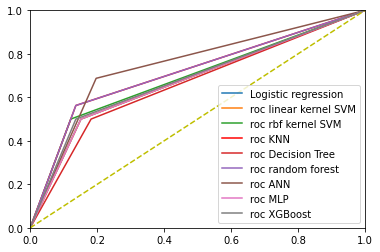

In [29]:
lrfpr,lrtpr,threshold=roc_curve(y_test1,lry_pred)
lsvmfpr,lsvmtpr,threshold1=roc_curve(y_test1,lsvmy_pred)
rbfsvmfpr,rbfsvmtpr,threshold2=roc_curve(y_test1,rbfsvmy_pred)
knnfpr,knntpr,threshold3=roc_curve(y_test1,knny_pred)
dtfpr,dttpr,threshold4=roc_curve(y_test1,dty_pred)
rffpr,rftpr,threshold5=roc_curve(y_test1,rfy_pred)
annfpr,anntpr,threshold6=roc_curve(y_test1,anny_pred)
mlpfpr,mlptpr,threshold7=roc_curve(y_test1,mlpy_pred)
xgbfpr,xgbtpr,threshold8=roc_curve(y_test1,xgby_pred)


print(roc_auc_score(y_test1,lry_pred))
print(roc_auc_score(y_test1,lsvmy_pred))
print(roc_auc_score(y_test1,rbfsvmy_pred))
print(roc_auc_score(y_test1,knny_pred))
print(roc_auc_score(y_test1,dty_pred))
print(roc_auc_score(y_test1,rfy_pred))
print(roc_auc_score(y_test1,anny_pred))
print(roc_auc_score(y_test1,mlpy_pred))
print(roc_auc_score(y_test1,xgby_pred))


plt.figure()
plt.plot(lrfpr,lrtpr,label="Logistic regression")
plt.plot(lsvmfpr,lsvmtpr,label='roc linear kernel SVM')
plt.plot(rbfsvmfpr,rbfsvmtpr,label='roc rbf kernel SVM')
plt.plot(knnfpr,knntpr,label='roc KNN',color="red")
plt.plot(dtfpr,dttpr,label='roc Decision Tree')
plt.plot(rffpr,rftpr,label='roc random forest')
plt.plot(annfpr,anntpr,label='roc ANN')
plt.plot(mlpfpr,mlptpr,label='roc MLP')
plt.plot(xgbfpr,xgbtpr,label='roc XGBoost')
plt.plot([0,1],[0,1],'y--')
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend()
plt.show()